*Read section 8.1.2 of the book before using these notes.*

*Note that in this course, lecture notes are not sufficient, you must read the book for better understanding. Lecture notes are just implementing the concepts of the book on a dataset, but not explaining the concepts elaborately.*

In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score,train_test_split
from sklearn.metrics import roc_curve, precision_recall_curve, auc, make_scorer, recall_score, accuracy_score, precision_score, confusion_matrix
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

#Libraries for visualizing trees
from sklearn.tree import export_graphviz 
from six import StringIO
from IPython.display import Image  
import pydotplus

import time as time

In [5]:
train = pd.read_csv('diabetes_train.csv')
test = pd.read_csv('diabetes_test.csv')

In [6]:
test.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,2,197,70,45,543,30.5,0.158,53,1
2,1,115,70,30,96,34.6,0.529,32,1
3,8,99,84,0,0,35.4,0.388,50,0
4,7,147,76,0,0,39.4,0.257,43,1


## Building a classification tree
Develop a classification tree to predict if a person has diabetes

In [11]:
X = train.drop(columns = 'Outcome')
Xtest = test.drop(columns = 'Outcome')
y = train['Outcome']
ytest = test['Outcome']

In [12]:
#Defining the object to build a regression tree
model = DecisionTreeClassifier(random_state=1, max_depth=3) 

#Fitting the regression tree to the data
model.fit(X, y)

DecisionTreeClassifier(max_depth=3, random_state=1)

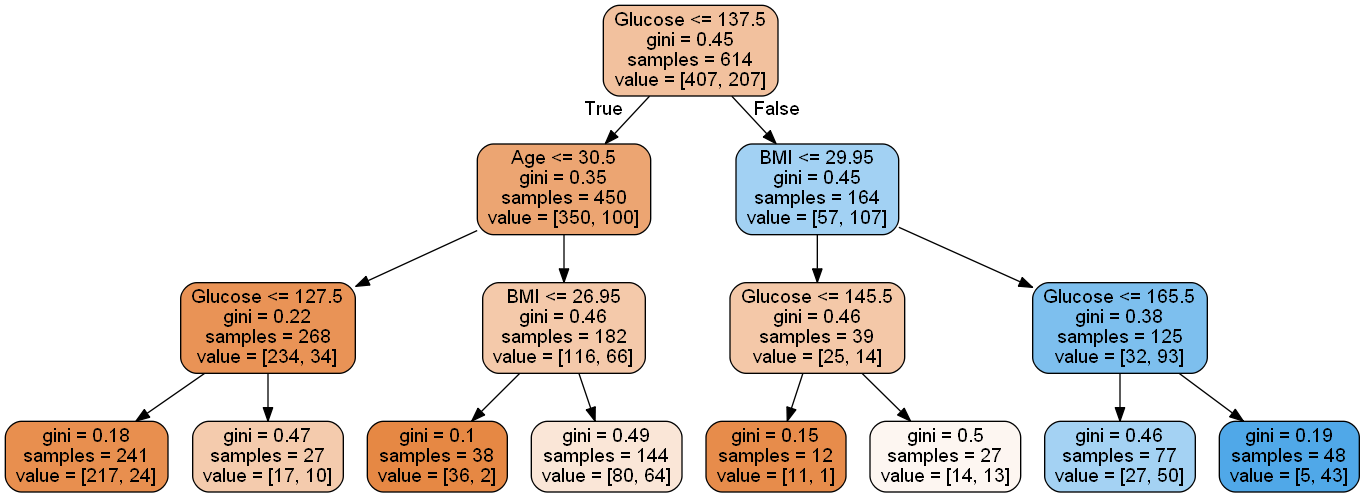

In [6]:
#Visualizing the regression tree
dot_data = StringIO()
export_graphviz(model, out_file=dot_data,  
                filled=True, rounded=True,
                feature_names =X.columns,precision=2)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
#graph.write_png('car_price_tree.png')
Image(graph.create_png())

In [17]:
#Function to compute confusion matrix and prediction accuracy on test/train data
def confusion_matrix_data(data,actual_values,model,cutoff=0.5):
#Predict the values using the Logit model
    pred_values = model.predict_proba(data)[:,1]
# Specify the bins
    bins=np.array([0,cutoff,1])
#Confusion matrix
    cm = np.histogram2d(actual_values, pred_values, bins=bins)[0]
    cm_df = pd.DataFrame(cm)
    cm_df.columns = ['Predicted 0','Predicted 1']
    cm_df = cm_df.rename(index={0: 'Actual 0',1:'Actual 1'})
# Calculate the accuracy
    accuracy = 100*(cm[0,0]+cm[1,1])/cm.sum()
    fnr = 100*(cm[1,0])/(cm[1,0]+cm[1,1])
    precision = 100*(cm[1,1])/(cm[0,1]+cm[1,1])
    fpr = 100*(cm[0,1])/(cm[0,0]+cm[0,1])
    tpr = 100*(cm[1,1])/(cm[1,0]+cm[1,1])
    print("Accuracy = ", accuracy)
    print("Precision = ", precision)
    print("FNR = ", fnr)
    print("FPR = ", fpr)
    print("TPR or Recall = ", tpr)
    print("Confusion matrix = \n", cm_df)
    return (" ")

In [18]:
#prediction on test data
pred=model.predict_proba(Xtest)[:,0]

In [19]:
confusion_matrix_data(X,train.Outcome,model,cutoff=0.4)

Accuracy =  73.45276872964169
Precision =  57.432432432432435
FNR =  17.8743961352657
FPR =  30.95823095823096
TPR or Recall =  82.1256038647343
Confusion matrix = 
           Predicted 0  Predicted 1
Actual 0        281.0        126.0
Actual 1         37.0        170.0


' '

## Optimizing parameters to improve the classification tree
In case of diabetes, it is important to reduce FNR (False negative rate). This is because if a person has diabetes, the consequences of predicting that they don't have diabetes can be much worse than the other way round.

Let us find the optimal depth of the tree and the number of terminal nods (leaves) that minimizes the FNR.

In [10]:
#Defining parameters and the range of values over which to optimize
param_grid = {    
    'max_depth': range(1,10),
    'max_leaf_nodes': range(10,30)
}

In [11]:
#Grid search to optimize parameter values

skf = StratifiedKFold(n_splits=5)#The folds are made by preserving the percentage of samples for each class.

#Minimizing FNR is equivalent to maximizing recall
grid_search = GridSearchCV(DecisionTreeClassifier(random_state=1), param_grid, scoring=['precision','recall','accuracy'], 
                           refit="recall", cv=skf, n_jobs=-1, verbose = True)
grid_search.fit(X, y)

# make the predictions
y_pred = grid_search.predict(Xtest)

print('Best params for recall')
print(grid_search.best_params_)

Fitting 5 folds for each of 180 candidates, totalling 900 fits
Best params for recall
{'max_depth': 4, 'max_leaf_nodes': 13}


In [20]:
#All results of the grid search can be seen with cv_results_
cv_scores = pd.DataFrame(grid_search.cv_results_)

NameError: name 'grid_search' is not defined

In [21]:
model = DecisionTreeClassifier(random_state=1, max_depth = 4, max_leaf_nodes=13)

model.fit(X,y)                            
print(confusion_matrix_data(X,train.Outcome,model))
print(confusion_matrix_data(Xtest,test.Outcome,model))

Accuracy =  80.78175895765472
Precision =  71.70731707317073
FNR =  28.985507246376812
FPR =  14.25061425061425
TPR or Recall =  71.01449275362319
Confusion matrix = 
           Predicted 0  Predicted 1
Actual 0        349.0         58.0
Actual 1         60.0        147.0
 
Accuracy =  77.92207792207792
Precision =  72.88135593220339
FNR =  29.508196721311474
FPR =  17.204301075268816
TPR or Recall =  70.49180327868852
Confusion matrix = 
           Predicted 0  Predicted 1
Actual 0         77.0         16.0
Actual 1         18.0         43.0
 


The model can be further tuned to reduce FNR (False negative rate) by reducing the decision threshold probability

In [22]:
print(confusion_matrix_data(X,train.Outcome,model,cutoff=0.2))
print(confusion_matrix_data(Xtest,test.Outcome,model,cutoff=0.2))

Accuracy =  72.63843648208469
Precision =  55.96330275229358
FNR =  11.594202898550725
FPR =  35.38083538083538
TPR or Recall =  88.40579710144928
Confusion matrix = 
           Predicted 0  Predicted 1
Actual 0        263.0        144.0
Actual 1         24.0        183.0
 
Accuracy =  76.62337662337663
Precision =  65.06024096385542
FNR =  11.475409836065573
FPR =  31.182795698924732
TPR or Recall =  88.52459016393442
Confusion matrix = 
           Predicted 0  Predicted 1
Actual 0         64.0         29.0
Actual 1          7.0         54.0
 


Tuning the threshold probability, with only 1% decrease in overall accuracy, the FNR on test data reduces from 30% to 11%.

## Optimizing the decision threshold probability

### Precision vs recall

In case of diabetes, it was important to reduce FNR. However, if we just optimize the model to have a low FNR (or high recall), it may reduce its precision. 

For example, if we reduce the threshold too much, the FNR will tend to 0 (or recall will tend to 1). However, the precision of predictions will be poor. In case of the diabetes example, for a threshold of 0.083, the FNR is 1% (or the recall is 99%), but the precision is 35% (see code below). This implies that only 1% of the people having diabetes will be predicted as "not having diabetes". However, only 35% of the people predicted as having diabetes actually have diabetes. Thus, there will be a considerable chance that people are predicted as having diabetes even if they don't have it. This will reduce the utility of the model. Thus, in this case, a threshold probability should be chosen such that it balances the desired FNR with a reasonable precision.

In some cases, precision with recall may be associated with different costs. Then, a threshold probability may be chosen to minimize the cost. 

**Example:** Suppose a classification model is developed to predict if a customer asking for a loan will default on the loan. If the model predicts that the customer will default, they are denied a loan. Otherwise their loan is approved. Assume that $r_p$ is the predicted response rate, $r_a$ is the actual response rate, $I_l$ is the interest amount lost for the customer who is predicted to default, but actually does not default, $P_l$ is the principal amount lost for the customer who is predicted to not default, but actually defaults, then the threshold probability to classify customers must be chosen to minimize the cost: $$n[r_p(1-precision)I_l+r_a(1-recall)P_l],$$ where $n$ is the total number of customers.

In [25]:
ypred = model.predict_proba(X)[:, 1]
p, r, thresholds = precision_recall_curve(y, ypred)

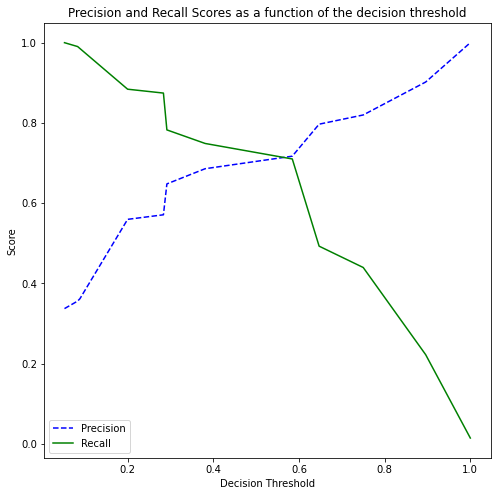

In [26]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.figure(figsize=(8, 8))
    plt.title("Precision and Recall Scores as a function of the decision threshold")
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.ylabel("Score")
    plt.xlabel("Decision Threshold")
    plt.legend(loc='best')
    
plot_precision_recall_vs_threshold(p, r, thresholds)

### ROC-AUC

The performance metrics that we have seen until now for classification problems, such as FNR, accuracy, precision, recall etc. depend on the threshold probability chosen for classification. Here, we will introduce a metric - the ROC curve, that is independent of the threshold probability. 

The ROC curve plots TPR (True positive rate) against FPR (False positive rate), for all possible thresholds. The name *ROC* comes from communications theory, and is an acronym for *receiver operating characteristics*. The AUC (Area Under the Curve) is the area under the ROC curve, and is an estimate of the probability that a classifier will rank a randomly chosen positive instance higher than a randomly chosen negative instance. Thus, the AUC is a classification error measure that does not rely upon a single threshold probability. 

AUC is desirable for the following two reasons *(Source: https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc)*:

1. AUC is scale-invariant. It measures how well predictions are ranked, rather than their absolute values.
2. AUC is classification-threshold-invariant. It measures the quality of the model's predictions irrespective of what classification threshold is chosen.

However, both these reasons come with caveats, which may limit the usefulness of AUC in certain use cases:

1. Scale invariance is not always desirable. For example, sometimes we really do need well calibrated probability outputs, and AUC won’t tell us about that.

2. Classification-threshold invariance is not always desirable. In cases where there are wide disparities in the cost of false negatives vs. false positives, it may be critical to minimize one type of classification error. For example, when doing email spam detection, you likely want to prioritize minimizing false positives (even if that results in a significant increase of false negatives). AUC isn't a useful metric for this type of optimization.

In [29]:
fpr, tpr, auc_thresholds = roc_curve(y, ypred)
print(auc(fpr, tpr))# AUC of ROC

0.8489121532599794


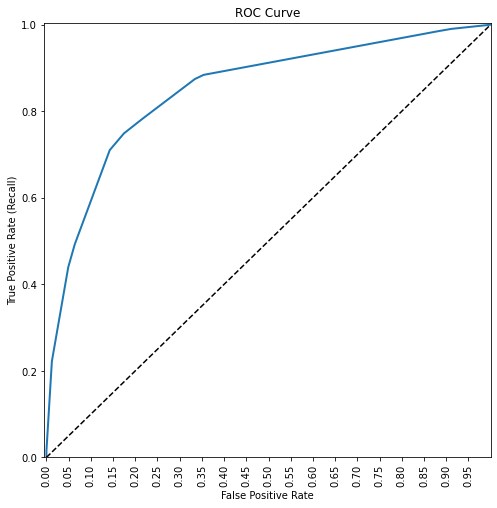

In [28]:
def plot_roc_curve(fpr, tpr, label=None):

    plt.figure(figsize=(8,8))
    plt.title('ROC Curve')
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([-0.005, 1, 0, 1.005])
    plt.xticks(np.arange(0,1, 0.05), rotation=90)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate (Recall)")

fpr, tpr, auc_thresholds = roc_curve(y, ypred)
plot_roc_curve(fpr, tpr)

AUC can be optimized with grid search just as we optimized recall earlier.

In [18]:
clf = DecisionTreeClassifier(random_state=1)
param_grid = {    
    'max_depth': range(1,10),
    'max_leaf_nodes': range(10,30),
    'max_features': range(3,8)
}

In [19]:
refit_score = "roc_auc"
"""
fits a GridSearchCV classifier using refit_score for optimization
prints classifier performance metrics
"""
skf = StratifiedKFold(n_splits=5)
grid_search = GridSearchCV(clf, param_grid, scoring=['precision','recall','accuracy','roc_auc'], refit=refit_score,
                       cv=skf, n_jobs=-1, verbose = True)
grid_search.fit(X, y)

# make the predictions
y_pred = grid_search.predict(Xtest)

print('Best params for', refit_score)
print(grid_search.best_params_)

Fitting 5 folds for each of 900 candidates, totalling 4500 fits
Best params for roc_auc
{'max_depth': 4, 'max_features': 5, 'max_leaf_nodes': 16}


In [30]:
model = DecisionTreeClassifier(random_state=1, max_depth = 4, max_leaf_nodes=16,max_features = 5)
model.fit(X,y)                            

DecisionTreeClassifier(max_depth=4, max_features=5, max_leaf_nodes=16,
                       random_state=1)

0.8651437999264087


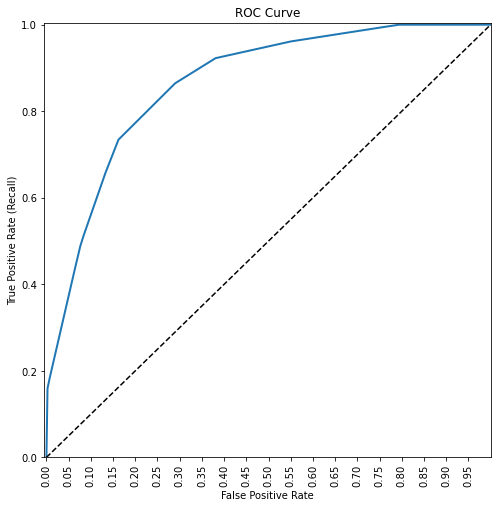

In [31]:
y_scores = model.predict_proba(X)[:, 1]
fpr, tpr, auc_thresholds = roc_curve(y, y_scores)
print(auc(fpr, tpr)) # AUC of ROC
plot_roc_curve(fpr, tpr)

0.8584523179975322


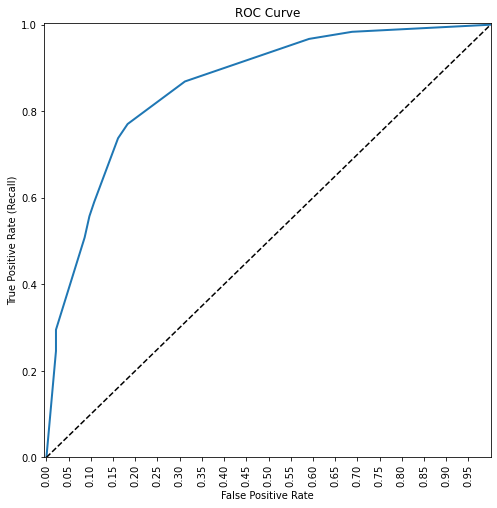

In [32]:
y_scores = model.predict_proba(Xtest)[:, 1]
fpr, tpr, auc_thresholds = roc_curve(ytest, y_scores)
print(auc(fpr, tpr)) # AUC of ROC
plot_roc_curve(fpr, tpr)

How can we use the ROC curve to determine a threshold?

**Example:** Suppose the model is to predict if a customer will respond to a marketing campaign. Assume the profit associated with a customer responding positively to the campaign is *p*, the loss associated with a customer not responding to the campaign is *l*, and *r* is the overall response rate, then the threshold probability for classifying observations must me chosen to maximize the total profit from the marketing campaign: $$ n[rp \times (TPR) - (1-r)l \times (FPR) ], $$ where $n$ is the number of people targeted in the campaign.

## Cost complexity pruning
Just as we did cost complexity pruning in a regression tree, we can do it to optimize the model for a classification tree.

In [25]:
model = DecisionTreeClassifier(random_state = 1)#model without any restrictions
path= model.cost_complexity_pruning_path(X,y)# Compute the pruning path during Minimal Cost-Complexity Pruning.

In [26]:
alphas=path['ccp_alphas']
len(alphas)

58

In [29]:
#Grid search to optimize parameter values

skf = StratifiedKFold(n_splits=5)
grid_search = GridSearchCV(DecisionTreeClassifier(random_state = 1), param_grid = {'ccp_alpha':alphas}, 
                                                  scoring=['precision','recall','accuracy'], 
                                                  refit="recall", cv=skf, n_jobs=-1, verbose = True)
grid_search.fit(X, y)

# make the predictions
y_pred = grid_search.predict(Xtest)

print('Best params for recall')
print(grid_search.best_params_)

Fitting 5 folds for each of 58 candidates, totalling 290 fits
Best params for recall
{'ccp_alpha': 0.010561291712538737}


In [38]:
tree = DecisionTreeClassifier(ccp_alpha=0.01435396,random_state=1)
tree.fit(X, y)
print(confusion_matrix_data(X,train.Outcome,tree,cutoff = 0.2))
print(confusion_matrix_data(Xtest,test.Outcome,tree, cutoff = 0.2))

Accuracy =  71.82410423452768
FNR =  17.391304347826086
Confusion matrix = 
           Predicted 0  Predicted 1
Actual 0        270.0        137.0
Actual 1         36.0        171.0
 
Accuracy =  75.97402597402598
FNR =  16.39344262295082
Confusion matrix = 
           Predicted 0  Predicted 1
Actual 0         66.0         27.0
Actual 1         10.0         51.0
 
